In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import sequence

import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers

from keras.utils.vis_utils import plot_model

from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, Embedding, concatenate
from keras.utils.vis_utils import plot_model
INPUT_PATH = "D:\\Northeastern\\100 pct undersample split\\"

# Load Data

In [3]:
X_user_logs = np.load(INPUT_PATH + "train_user_logs_padded.npy")
X_user_logs.shape

(24798, 762, 7)

In [22]:
X_members = pd.read_csv(INPUT_PATH + "X_train_transformed.csv").sort_values("msno").drop(["msno"],axis=1).values
y = pd.read_csv(INPUT_PATH + "y_train.csv", header=None).sort_values(0).drop([0],axis=1).values

In [27]:
num_members_cols = X_members.shape[1]
num_members_cols

27

# Multi Input Example

In [ ]:
batch_size = 100
num_batch = 250
num_integers = 10
epochs = 3
lstm_units = 16

num_members = X_user_logs.shape[0]
num_dates = X_user_logs.shape[1]
num_user_log_cols = X_user_logs.shape[2]
num_member_cols = X_members.shape[1]

data_in_a = Input(shape = (num_dates,num_user_log_cols))
a = LSTM(lstm_units)(data_in_a)
a_mod = Model(data_in_a, outputs=a)

data_in_b = Input(shape = (num_member_cols,))
b = Dense(5, activation='relu')(data_in_b)
b_mod = Model(data_in_b, outputs=b)

combined = concatenate([a_mod.output, b_mod.output])

c = Dropout(0.2)(combined)
c = Dense(1, activation='softmax')(c)

model = Model(inputs=[a_mod.input, b_mod.input], outputs=c)
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

#model.summary()
model.fit([X_user_logs, X_members], y, batch_size=batch_size, epochs=epochs,verbose=1)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/3





 6500/24798 [======>.......................] - ETA: 2:31 - loss: 7.9025 - acc: 0.5043

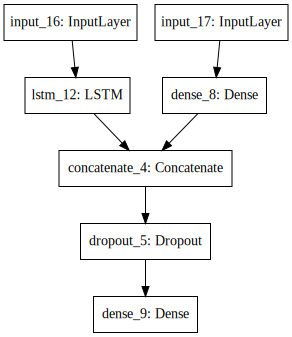

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))